## Import library and load data

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import pyarrow.parquet as pq

In [ ]:
# Mount
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load merged df as a table
DATA_PATH_MERGED = "/content/drive/MyDrive/BT4222 Group 3/1. Data Preparation/Data/features_engineered/user_behavior_data_sampled_parsed_features_merged.parquet"

queries_table_with_engineered_merged = pq.read_table(DATA_PATH_MERGED)
queries_df = pd.DataFrame(queries_table_with_engineered_merged.to_pydict())

In [ ]:
queries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173831 entries, 0 to 173830
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   query                      173831 non-null  object 
 1   candidate_wid_list         173831 non-null  object 
 2   candidate_label_list       173831 non-null  object 
 3   history_qry_list           173831 non-null  object 
 4   history_wid_list           173831 non-null  object 
 5   history_type_list          173831 non-null  object 
 6   history_time_list          173831 non-null  object 
 7   candidate_label_list_int   173831 non-null  object 
 8   history_type_list_ordinal  173831 non-null  object 
 9   query_list                 173831 non-null  object 
 10  history_qry_list_terms     173831 non-null  object 
 11  nunique_cats_1             173831 non-null  float64
 12  nunique_cats_2             173831 non-null  float64
 13  nunique_cats_3             17

In [ ]:
# check for empty lists
empty_wid = queries_df['history_wid_list'].apply(lambda x: len(x) == 0)
empty_qry = queries_df['history_qry_list'].apply(lambda x: len(x) == 0)

print("Empty history_wid_list:", empty_wid.sum())
print("Empty history_qry_list:", empty_qry.sum())


Empty history_wid_list: 4515
Empty history_qry_list: 4515


4515 (out of 173831) customers have empty histories

**Checking history length distribution**

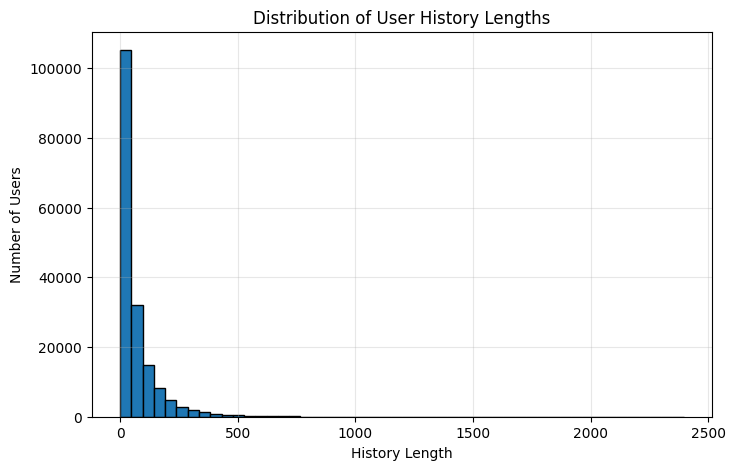

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(queries_df['history_len'], bins=50, edgecolor='black')
plt.title('Distribution of User History Lengths')
plt.xlabel('History Length')
plt.ylabel('Number of Users')
plt.grid(alpha=0.3)
plt.show()


Some history lengths are longer (more than 100), so we would want to add **attention** for users with longer history sequences.

### LSTM + Attention

First we define some parameters.
- `max_len`: Limits each user's interaction sequence to the most recent 200 actions. This prevents excessively long sequences from slowing down training and keeps memory usage manageable

- `batch_size`: Number of users processed in a single batch during training or embedding computation.

In [ ]:
# 1. Parameters
max_len = 200  # truncate sequences to last 200 interactions
batch_size = 64


Build vocabularies for embeddings

- Item IDs (`wid2idx`): Maps each unique item ID (WID) in the dataset to an integer index for embedding lookup. Index 0 is reserved for padding.

- Interaction types (`type2idx`): Maps each ordinal interaction type (click, add to cart, purchase, etc.) to an index for embedding.

- Time bins:
  - Interaction timestamps are log-scaled to handle large variations in time gaps.
  - Divides the timestamps into 10 bins using np.digitize for discretized embedding.


This step converts categorical and continuous interaction data into integer indices suitable for embeddings.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

all_wids = set([wid for sublist in queries_df['history_wid_list'] for wid in sublist])
wid2idx = {wid: i+1 for i, wid in enumerate(all_wids)}  # 0 = padding

# use ordinal type list
all_types = set([t for sublist in queries_df['history_type_list_ordinal'] for t in sublist])
type2idx = {t: i+1 for i, t in enumerate(all_types)}  # 0 = padding

# log-scaled time bins
all_times = [t for sublist in queries_df['history_time_list'] for t in sublist]
log_times = np.log1p(all_times)
num_bins = 10
bins = np.expm1(np.linspace(log_times.min(), log_times.max(), num_bins))
bins = np.round(bins).astype(int)

print(f"WIDs: {len(wid2idx)}, Types: {len(type2idx)}, Time bins: {len(bins)}")

WIDs: 474040, Types: 4, Time bins: 10
Dataset size: 173831, batches: 2717


**Dataset class**

Wraps the user history data into a PyTorch Dataset object for easy batching.

`__getitem__`:
- Truncates sequences to the last max_len interactions.
- Maps IDs/types/times to integer indices using the vocabularies and bins.
- Converts lists to PyTorch tensors, ready for embedding layers.

In [ ]:

class UserHistoryDataset(Dataset):
    def __init__(self, df, wid2idx, type2idx, bins, max_len=200):
        self.df = df
        self.wid2idx = wid2idx
        self.type2idx = type2idx
        self.bins = bins
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        wid_seq = row['history_wid_list'][-self.max_len:]
        type_seq = row['history_type_list_ordinal'][-self.max_len:]
        time_seq = row['history_time_list'][-self.max_len:]

        wid_seq = [self.wid2idx.get(w, 0) for w in wid_seq]
        type_seq = [self.type2idx.get(t, 0) for t in type_seq]
        time_seq = [np.digitize(t, self.bins) for t in time_seq]

        return {
            'wid_seq': torch.tensor(wid_seq, dtype=torch.long),
            'type_seq': torch.tensor(type_seq, dtype=torch.long),
            'time_seq': torch.tensor(time_seq, dtype=torch.long),
        }

Collate function for padding

- Users have different sequence lengths. LSTMs and other sequence models require uniform batch dimensions.

- `pad_sequence`: pads shorter sequences with 0 (the reserved padding index)

- `lengths` keeps track of the original sequence length for masking or packing in LSTM.

Returns a **batch dictionary** with padded sequences and sequence lengths.

In [ ]:

def collate_fn(batch):
    wid_seqs = pad_sequence([b['wid_seq'] for b in batch], batch_first=True, padding_value=0)
    type_seqs = pad_sequence([b['type_seq'] for b in batch], batch_first=True, padding_value=0)
    time_seqs = pad_sequence([b['time_seq'] for b in batch], batch_first=True, padding_value=0)
    lengths = torch.tensor([len(b['wid_seq']) for b in batch], dtype=torch.long)
    return {
        'wid_seq': wid_seqs,
        'type_seq': type_seqs,
        'time_seq': time_seqs,
        'lengths': lengths
    }

# initalise dataset and dataloader
dataset = UserHistoryDataset(queries_df, wid2idx, type2idx, bins, max_len=max_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Dataset size: {len(dataset)}, batches: {len(dataloader)}")


### generating the embeddings

**Goal**: Generate a dense, fixed-size embedding for each user that captures their sequential interaction patterns with items.

**Design Choices**:
1. LSTM (Long Short-Term Memory)
- Handles sequences of varying lengths.
- Captures temporal dependencies, i.e., how past actions influence future behavior.

2. Attention Layer
-Aggregates LSTM outputs into a single embedding.
- Allows the model to focus on important interactions rather than treating all past actions equally.

3. Embedding Sum
- User interactions have three components: product ID, interaction type, and time.
- We sum their embeddings to get a combined representation for each time step.

4. Empty History Handling
- Some users have no historical interactions.
- Use a learnable parameter `empty_user_emb` as a default embedding.
- Ensures these users still get a valid representation without breaking the model.

5. Batch Processing with Padding & Packing
- `pad_sequence` ensures all sequences in a batch have the same length.
- `pack_padded_sequence` allows LSTM to ignore padding efficiently, preserving variable-length information.

6. Precomputation

- Embeddings are computed once and stored, allowing fast usage in downstream tasks without recomputing every time.

In [ ]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn

# device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)


# 1. embedding layers + LSTM + Attention

emb_dim = 64
# embedding layers for:
# 1. item ids (wid)
# 2. interaction type (ordinal)
# 3. time bins (discretized time intervals)
item_emb = nn.Embedding(len(wid2idx)+1, emb_dim, padding_idx=0).to(device)
type_emb = nn.Embedding(len(type2idx)+1, emb_dim, padding_idx=0).to(device)
time_emb = nn.Embedding(len(bins)+1, emb_dim, padding_idx=0).to(device)

# LSTM to capture sequential patterns in user interactions
lstm = nn.LSTM(input_size=emb_dim, hidden_size=emb_dim, batch_first=True).to(device)


# attention mechanism to compute weighted sum of LSTM outputs
# so the model can focus on the most important interactions
class Attention(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.attn = nn.Linear(emb_dim, 1)

    def forward(self, x, mask):
        scores = self.attn(x).squeeze(-1)  # (batch, seq_len)
        scores = scores.masked_fill(mask == 0, float('-inf'))
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)  # (batch, seq_len, 1)
        out = (x * weights).sum(dim=1)
        return out

attention = Attention(emb_dim).to(device)

# learnable embedding for empty-history users
empty_user_emb = nn.Parameter(torch.zeros(1, emb_dim)).to(device)

# 2. compute user_dynamic_emb_attention

user_dynamic_emb_attention_list = []

with torch.no_grad():
    for batch in dataloader:
        wid_seq = batch['wid_seq'].to(device)
        type_seq = batch['type_seq'].to(device)
        time_seq = batch['time_seq'].to(device)
        lengths = batch['lengths'].to(device)

        mask = (wid_seq != 0) # padding mask

        # sum embeddings of each feature
        x = item_emb(wid_seq) + type_emb(type_seq) + time_emb(time_seq)  # (batch, seq_len, emb_dim)

        # initialize batch embedding with empty user embedding
        batch_emb = empty_user_emb.repeat(x.size(0), 1)  # (batch, emb_dim)

        # select users with non-empty histories
        non_empty_mask = lengths > 0
        if non_empty_mask.any():
            x_non_empty = x[non_empty_mask]
            lengths_non_empty = lengths[non_empty_mask]
            mask_non_empty = mask[non_empty_mask]
            # pack sequences for LSTM (handle variable lengths)
            packed = pack_padded_sequence(x_non_empty, lengths_non_empty.cpu(), batch_first=True, enforce_sorted=False)
            packed_out, (h_n, c_n) = lstm(packed)
            out, _ = pad_packed_sequence(packed_out, batch_first=True)

            # apply attention to LSTM outputs
            user_emb_non_empty = attention(out, mask_non_empty)

            # replace embeddings for non-empty users
            batch_emb[non_empty_mask] = user_emb_non_empty
        # store batch embeddings
        user_dynamic_emb_attention_list.append(batch_emb.cpu())

# concatenate all batches to form final tensor
user_dynamic_emb_attention = torch.cat(user_dynamic_emb_attention_list, dim=0)
# sanity check
print("user_dynamic_emb_attention shape:", user_dynamic_emb_attention.shape)
print("min/max/mean/std:", user_dynamic_emb_attention.min(),
      user_dynamic_emb_attention.max(),
      user_dynamic_emb_attention.mean(),
      user_dynamic_emb_attention.std())


Using device: cuda
user_dynamic_emb_attention shape: torch.Size([173831, 64])
min/max/mean/std: tensor(-0.7871) tensor(0.7979) tensor(-0.0234) tensor(0.1616)


In [ ]:
print("NaNs:", torch.isnan(user_dynamic_emb_attention).sum())
print("Infs:", torch.isinf(user_dynamic_emb_attention).sum())


NaNs: tensor(0)
Infs: tensor(0)


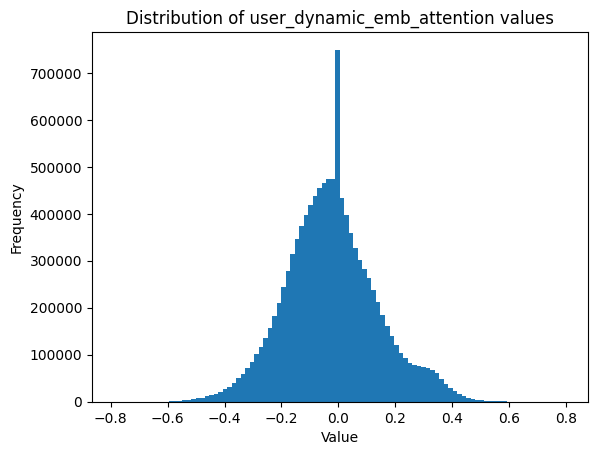

In [ ]:
import matplotlib.pyplot as plt

plt.hist(user_dynamic_emb_attention.cpu().numpy().flatten(), bins=100)
plt.title("Distribution of user_dynamic_emb_attention values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import os
import joblib
ARTIFACT_DIR = "/content/drive/MyDrive/BT4222 Group 3/2. Models/Artifacts/lstm_attention"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# 1️⃣ Save learned module weights
torch.save({
    'item_emb': item_emb.state_dict(),
    'type_emb': type_emb.state_dict(),
    'time_emb': time_emb.state_dict(),
    'lstm': lstm.state_dict(),
    'attention': attention.state_dict(),
    'empty_user_emb': empty_user_emb.data,
}, os.path.join(ARTIFACT_DIR, "embedding_attention_model.pt"))

# 2️⃣ Save index mappings
joblib.dump({
    'wid2idx': wid2idx,
    'type2idx': type2idx,
    'bins': bins
}, os.path.join(ARTIFACT_DIR, "index_mappings.pkl"))

# 3️⃣ Save precomputed embeddings (if you want to reuse directly)
torch.save(user_dynamic_emb_attention, os.path.join(ARTIFACT_DIR, "user_dynamic_emb_attention.pt"))

print("✅ Saved model weights, index mappings, and embeddings to:", ARTIFACT_DIR)

✅ Saved model weights, index mappings, and embeddings to: /content/drive/MyDrive/BT4222 Group 3/2. Models/Artifacts/lstm_attention
